# Example 10.3

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def taylor_method1(f, x0, y0, N):

    der = [y0]

    y1 = f.subs({x:x0, y:y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)
        
        subs_dic = {x:x0, y:y0}
        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]
        
        val = current.subs(subs_dic)
        der.append(val)
        
    T = 0
    for k in range(N):
        T += der[k] *(x - x0)**k / sp.factorial(k)
    return T, der
x = sp.Symbol('x')
y = sp.Function('y')(x)
f = x + y

T, der = taylor_method1(f, 0, 1, 6)
print('Derivatives at (x=x0) =', der)
print('Taylor Series =', T)
print(f'Taylor Series at (x=0.1) = {T.subs(x, 0.1):.6f}')
print(f'Talyor Series at (x=0.2) = {T.subs(x, 0.2):.6f}')

Derivatives at (x=x0) = [1, 1, 2, 2, 2, 2]
Taylor Series = x**5/60 + x**4/12 + x**3/3 + x**2 + x + 1
Taylor Series at (x=0.1) = 1.110342
Talyor Series at (x=0.2) = 1.242805


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam Iter 0, Loss 1.505e+00
Adam Iter 1000, Loss 9.505e-05
Adam Iter 2000, Loss 5.901e-05
Adam Iter 3000, Loss 3.248e-05
Adam Iter 4000, Loss 1.396e-05
Adam Iter 5000, Loss 2.858e-06
Adam Iter 6000, Loss 2.659e-06
Adam Iter 7000, Loss 2.562e-07
Adam Iter 8000, Loss 1.566e-07
Adam Iter 9000, Loss 1.290e-07

PINN Solution:
y(0.1) = 1.110340, y(0.2) = 1.242802


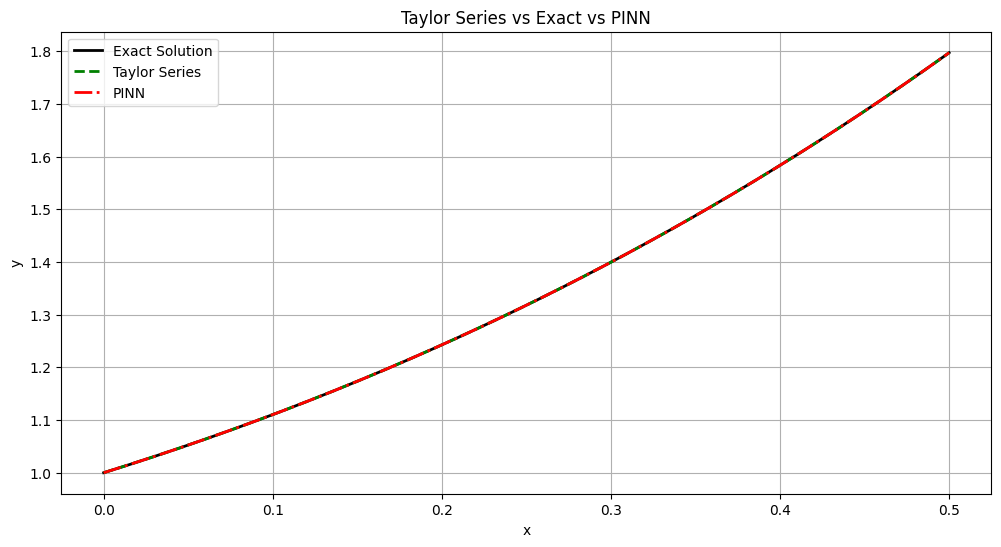

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# ===================================
# PINN for Example 10.3
# ===================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

x_colloc = torch.linspace(0, 0.5, 200, dtype=torch.float32, device=device, requires_grad=True).reshape(-1, 1)

x0 = torch.tensor([[0.0]], dtype=torch.float32, device=device)
y0 = torch.tensor([[1.0]], dtype=torch.float32, device=device)

def pinn_loss():
    y = model(x_colloc)
    dy = torch.autograd.grad(y, x_colloc, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    f = dy - y - x_colloc
    loss_pde = torch.mean(f**2)
    
    y0_pred = model(x0)
    loss_ic = torch.mean((y0_pred - y0)**2)
    
    return loss_pde + loss_ic

optimizer_adam = optim.Adam(model.parameters(), lr=5e-4)

for it in range(10000):
    optimizer_adam.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer_adam.step()
    if it % 1000 == 0:
        print(f'Adam Iter {it}, Loss {loss.item():.3e}')

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, line_search_fn='strong_wolfe')

def closure():
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()
    return loss
optimizer_lbfgs.step(closure)

x_pinn_vals = torch.tensor([[0.1], [0.2]], dtype=torch.float32, device=device)
y_pinn = model(x_pinn_vals).detach().cpu().numpy().flatten()

print(f'\nPINN Solution:')
print(f'y(0.1) = {y_pinn[0]:.6f}, y(0.2) = {y_pinn[1]:.6f}')

# ===================================
# Enhanced Plot with PINN
# ===================================
x_plot = np.linspace(0, 0.5, 200)
x_plot_torch = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32, device=device)
y_pinn_plot = model(x_plot_torch).detach().cpu().numpy().flatten()

exact_func_pinn = sp.lambdify(x, sp.dsolve(sp.Eq(sp.diff(y, x), x + y), y, ics={y.subs(x, 0): 1}).rhs, 'numpy')
exact_vals_pinn = exact_func_pinn(x_plot)
taylor_func_pinn = sp.lambdify(x, T, 'numpy')
taylor_vals_pinn = taylor_func_pinn(x_plot)

plt.figure(figsize=(12, 6))
plt.plot(x_plot, exact_vals_pinn, 'k-', label='Exact Solution', linewidth=2)
plt.plot(x_plot, taylor_vals_pinn, 'g--', label='Taylor Series', linewidth=2)
plt.plot(x_plot, y_pinn_plot, 'r-.', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Taylor Series vs Exact vs PINN')
plt.legend()
plt.grid(True)
plt.show()

# Example 10.4

In [46]:
import sympy as sp

def taylor_method2(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)
    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / (sp.factorial(k))
    return T, der

x = sp.Symbol('x')
y = sp.Function('y')(x)
f = x**2 * y - 1
T, der = taylor_method2(f, 0, 1, 6)
print('Taylor Polynomial =', T)
print('Derivatives =', der)
print(f'Taylor series at (x=0.1) = {T.subs(x, 0.1):.6f}')
print(f'Taylor series at (x=0.2) = {T.subs(x, 0.2):.6f}')

Taylor Polynomial = -x**4/4 + x**3/3 - x + 1
Derivatives = [1, -1, 0, 2, -6, 0]
Taylor series at (x=0.1) = 0.900308
Taylor series at (x=0.2) = 0.802267


# Example 10.5

In [66]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(y.diff(x), 2*y + 3*sp.exp(x))
exac_sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 0})
exact_series = sp.series(exac_sol.rhs, x, 0, 5).removeO()
print('Exact Solution =', exac_sol)
print('Exact Series Solution =', exact_series)
print(f'Exact Solution at (x=0.2) = {exac_sol.rhs.subs(x, 0.2):.6f}')

def taylor_method3(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}
        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)
    
    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)
    return T, der
f = 2 * y + 3 * sp.exp(x)
T, der = taylor_method3(f, 0, 0, 5)
print('Taylor Polynomial =',T)
print('Derivatives =', der)
print(f'Taylor series solution at (x=0.2) = {T.subs(x, 0.2):.6f}')

Exact Solution = Eq(y(x), (3*exp(x) - 3)*exp(x))
Exact Series Solution = 15*x**4/8 + 7*x**3/2 + 9*x**2/2 + 3*x
Exact Solution at (x=0.2) = 0.811266
Taylor Polynomial = 15*x**4/8 + 7*x**3/2 + 9*x**2/2 + 3*x
Derivatives = [0, 3, 9, 21, 45]
Taylor series solution at (x=0.2) = 0.811000


# Example 10.6

In [74]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)
f = (x**3 + x*y**2) / sp.exp(x)

def taylor_method4(f, x0, y0, N):

    der = [y0]

    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)
    return T, der
T, der = taylor_method4(f, 0, 1, 4)
print('Taylor Polynomial =', T)
print('derivatives =', der)
print(f'Taylor series solution at (x=0.1) = {T.subs(x, 0.1):.6f}')
print(f'Taylor series solution at (x=0.2) = {T.subs(x, 0.2):.6f}')
print(f'Taylor series solution at (x=0.3) = {T.subs(x, 0.3):.6f}')

Taylor Polynomial = -x**3/3 + x**2/2 + 1
derivatives = [1, 0, 1, -2]
Taylor series solution at (x=0.1) = 1.004667
Taylor series solution at (x=0.2) = 1.017333
Taylor series solution at (x=0.3) = 1.036000


# Example 10.7

In [10]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)
f = sp.log(x*y)

def taylor_series(f, x0, y0, N):

    der = [y0]
    y1 = sp.simplify(f.subs({x: x0, y: y0}))
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}
        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = sp.simplify(current.subs(subs_dic))
        der.append(val)
    
    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k /sp.factorial(k)
    return sp.simplify(T), der

T, der = taylor_series(f, 1, 2, 4)

print('Taylor Series =', T)
print(f'Taylor Series at (x=1.1) = {T.subs(x, 1.1):.6f}')
print(f'Taylor Series at (x=1.2) = {T.subs(x, 1.2):.6f}')

Taylor Series = (x - 1)**3*(-2 - log(2)**2 + log(2))/24 + (x - 1)**2*(log(2) + 2)/4 + (x - 1)*log(2) + 2
Taylor Series at (x=1.1) = 2.075973
Taylor Series at (x=1.2) = 2.164965


# Exercise 10.5

Exact Solution at (x=1.1) = 0.110342
Exact Solution at (x=1.2) = 0.242806

y_1(1.1) = 0.110342
y_2(1.2) = 0.242805
x + (x - 1)**5/60 + (x - 1)**4/12 + (x - 1)**3/3 + (x - 1)**2 - 1


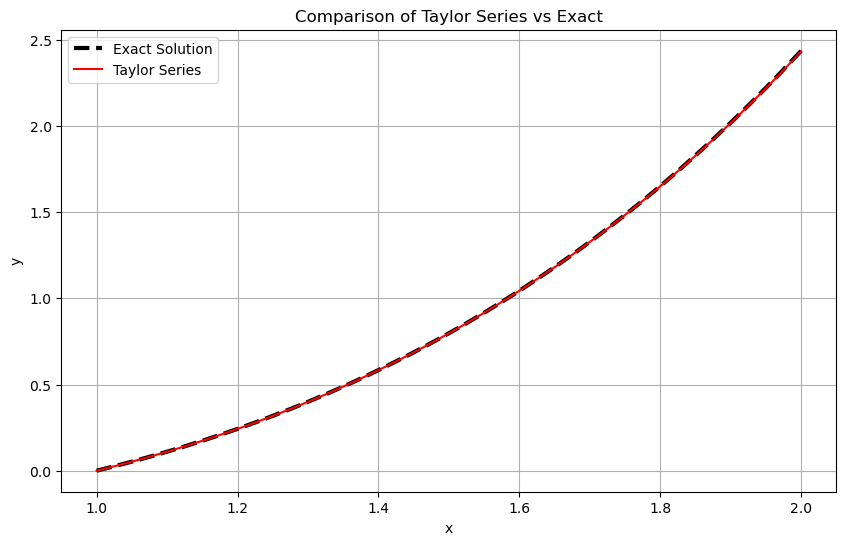

In [29]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(y.diff(x), x + y)
sol = sp.dsolve(ode, y, ics={y.subs(x, 1): 0})
series_sol = sp.series(sol.rhs, x, 0, 6).removeO()
print(f'Exact Solution at (x=1.1) = {sol.rhs.subs(x, 1.1):.6f}')
print(f'Exact Solution at (x=1.2) = {sol.rhs.subs(x, 1.2):.6f}')

def taylor_series(f, x0, y0, N):

    der = [y0]

    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)

    return T, der
f = x + y
T, der = taylor_series(f, 1, 0, 6)
print(f'\ny_1(1.1) = {T.subs(x, 1.1):.6f}')
print(f'y_2(1.2) = {T.subs(x, 1.2):.6f}')
print(T)

x_vals = np.linspace(1, 2, 200)
exact_func = sp.lambdify(x, sol.rhs, 'numpy')
exact_vals = exact_func(x_vals)
taylor_func = sp.lambdify(x, T, 'numpy')
taylor_vals = taylor_func(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, exact_vals, color='black', linestyle='--', linewidth=3, label='Exact Solution')
plt.plot(x_vals, taylor_vals, color='red', label='Taylor Series')
plt.title('Comparison of Taylor Series vs Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Exercise 10.6

Eq(y(x), sqrt(pi)*exp(-x**2)*erfi(x)/2)
Exact Solution at (x=0.2) = 0.194751

Taylor Series y(0.2) = 0.194752


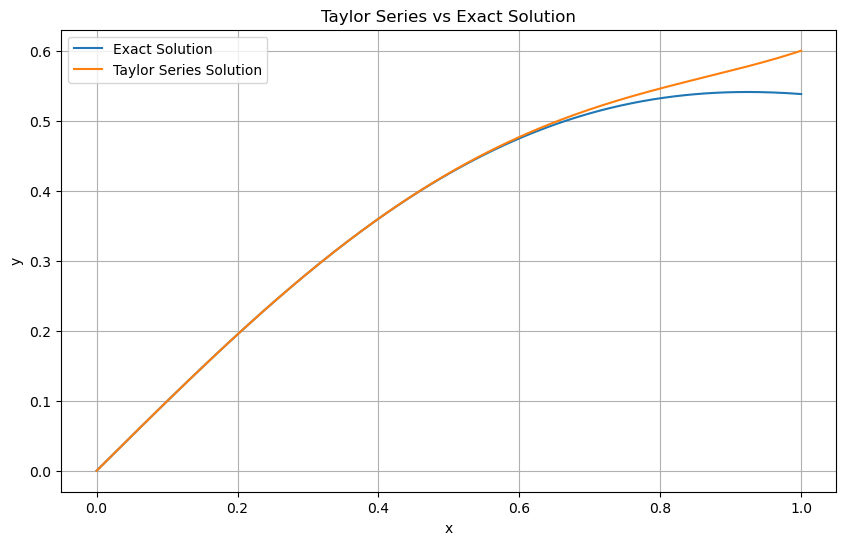

In [17]:
import sympy as sp
import numpy as np
from scipy.special import erfi
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(y.diff(x), 1 - 2*x*y)
sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 0})
print(sol)
print(f'Exact Solution at (x=0.2) = {sol.rhs.subs(x, 0.2):.6f}')

def taylor_series(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}
        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)

    return T, der

f = 1 - 2*x*y
T, der = taylor_series(f, 0, 0, 6)
print(f'\nTaylor Series y(0.2) = {T.subs(x, 0.2):.6f}')

x_vals = np.linspace(0, 1, 200)
exact_func = sp.lambdify(x, sol.rhs, modules=['numpy', 'scipy'])
exact_vals = exact_func(x_vals)
taylor_func = sp.lambdify(x, T, 'numpy')
taylor_vals = taylor_func(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, exact_vals, label='Exact Solution')
plt.plot(x_vals, taylor_vals, label='Taylor Series Solution')
plt.title('Taylor Series vs Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.7

Exact Solution = 1.105347
Taylor Series y(0.1) = 1.105346


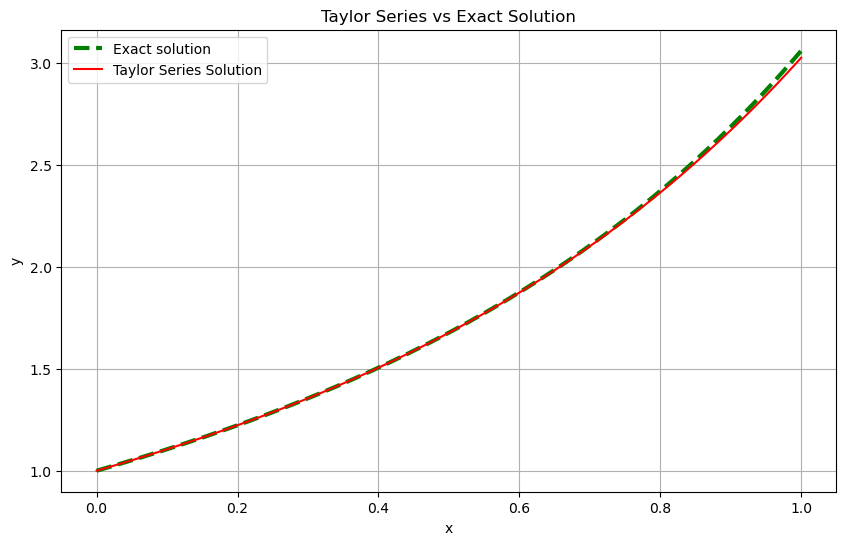

In [30]:
import sympy as sp
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

x = sp.Symbol('x')
y = sp.Function('y')(x)

ode = sp.Eq(y.diff(x), x*y + 1)
sol = sp.dsolve(ode, y, ics={y.subs(x, 0): 1})
print(f'Exact Solution = {sol.rhs.subs(x, 0.1):.6f}')

def taylor_series(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)

    return T, der
f = x*y + 1
T, der = taylor_series(f, 0, 1, 6)
print(f'Taylor Series y(0.1) = {T.subs(x, 0.1):.6f}')

x_vals = np.linspace(0, 1, 200)
exact_func = sp.lambdify(x, sol.rhs, modules=['numpy', 'scipy'])
exact_vals = exact_func(x_vals)
taylor_func = sp.lambdify(x, T, 'numpy')
taylor_vals = taylor_func(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, exact_vals, color='green', linestyle='--', linewidth=3, label='Exact solution')
plt.plot(x_vals, taylor_vals, color='red', label='Taylor Series Solution')
plt.title('Taylor Series vs Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Exercise 10.8

In [36]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)

def taylor_series(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f
    for k in range(2, N):

        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)

    return T, der
f = y**2 + x
T, der = taylor_series(f, 0, 1, 6)
print(f'Taylor Series at (x=0.1) = {T.subs(x, 0.1):.6f}')
print(f'Taylor Series at (x=0.2) = {T.subs(x, 0.2):.6f}')

Taylor Series at (x=0.1) = 1.116490
Taylor Series at (x=0.2) = 1.273429


# Exercise 10.9

In [39]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)

def taylor_series(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):
        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]

        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)

    return T, der
f = x**2 + y**2
T, der = taylor_series(f, 0, 1, 6)
print(f'Taylor Series at (x=0.1) = {T.subs(x, 0.1):.6f}')

Taylor Series at (x=0.1) = 1.111462


# Exercise 10.10

In [43]:
import sympy as sp

x = sp.Symbol('x')
y = sp.Function('y')(x)

def taylor_series(f, x0, y0, N):

    der = [y0]
    y1 = f.subs({x: x0, y: y0})
    der.append(y1)

    current = f

    for k in range(2, N):

        current = sp.diff(current, x)

        subs_dic = {x: x0, y: y0}

        for i in range(1, k):
            subs_dic[sp.diff(y, x, i)] = der[i]
        
        val = current.subs(subs_dic)
        der.append(val)

    T = 0
    for k in range(N):
        T += der[k] * (x - x0)**k / sp.factorial(k)

    return T, der
f = sp.exp(x) - y**2
T, der = taylor_series(f, 0, 1, 6)
print(f'Taylor Series at (x=0.1) = {T.subs(x, 0.1):.4}')

Taylor Series at (x=0.1) = 1.005
